In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import sys
import halfspace.projections as hsp
import time

import halfspace.stress_comps_vectorized as scv

sys.path.append('/Users/itchy/research/stress/aux_scripts/')
from stress_plots import rose, scatter_w_marginals

In [112]:
out_name = '../results/nepal_tect_posteriors.csv'
fault_file = '../data/fault_data/fault_pts_stresses.csv'
fault_file = '../data/fault_data/all_fault_pts.csv'
eq_file = '../data/fault_data/eq_pts_stresses.csv'

fd = pd.read_csv(fault_file, index_col=0)
eqs = pd.read_csv(eq_file)

fd = pd.concat([fd, eqs])

fd.fault_name.fillna('nan', inplace=True)

fdf = fd

#fdf = fd[[False if 'aftershock' in fn else True for fn in fd.fault_name] ]

In [113]:
fdf.head()

,EVENT_ID,depth,dip,east,fault_name,htm_ind,north,point_index,rake,sig_nn,slip_m,strike,tau_dd,tau_ss,xx_stress,xy_stress,xz_stress,yy_stress,yz_stress,zz_stress
0,NaN,4623,55,210702.346219,nan,30,3295884.106254,0,-90,NaN,0.1,19.761917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,4762,55,205435.348084,nan,30,3287130.049210,1,-90,NaN,0.1,19.761917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,4831,55,200405.436713,nan,30,3267428.950486,2,-90,NaN,0.1,19.761917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,4677,55,200853.134701,nan,30,3259918.710871,3,-90,NaN,0.1,19.761917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,4797,55,198732.170284,nan,30,3242085.302656,4,-90,NaN,0.1,19.761917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [114]:
fdf.shape

(1797, 20)

In [108]:
fd.shape

(1157, 20)

In [95]:
fdf['ind'] = fdf.index.values.astype('float')

In [96]:
fdf.head()

,EVENT_ID,depth,dip,east,fault_name,htm_ind,north,point_index,rake,sig_nn,...,strike,tau_dd,tau_ss,xx_stress,xy_stress,xz_stress,yy_stress,yz_stress,zz_stress,ind
46,NaN,-900,55,187652.100681,nan,30,3201695.699761,46,-90,107.406454,...,19.761917,22.818001,-8.014952,116.635841,-23.592039,7.047159,116.559867,-15.262829,91.660655,46
47,NaN,-905,55,182389.018021,nan,30,3189482.756855,47,-90,115.069749,...,19.761917,24.610810,-20.692174,112.519571,-26.335601,-1.674472,123.656915,2.729693,76.353217,47
48,NaN,-952,55,177410.108366,nan,30,3184445.612939,48,-90,124.934737,...,19.761917,18.885294,-32.397864,112.488335,-33.332509,0.691854,135.714470,9.537297,94.288301,48
49,NaN,-1285,55,173003.190810,nan,30,3180027.682572,49,-90,137.625834,...,19.761917,14.087774,-15.785102,125.441811,-32.452741,-4.658254,117.593029,-3.281453,112.830067,49
50,NaN,-1284,55,168449.167252,nan,30,3177094.112030,50,-90,110.175997,...,19.761917,24.153216,-0.631182,127.878486,-18.535620,10.384544,116.612641,-18.818548,98.725853,50


In [97]:
fdf.loc[fdf.rake==-90, 'slip_m'] = 0.05

fdf.head()

,EVENT_ID,depth,dip,east,fault_name,htm_ind,north,point_index,rake,sig_nn,...,strike,tau_dd,tau_ss,xx_stress,xy_stress,xz_stress,yy_stress,yz_stress,zz_stress,ind
46,NaN,-900,55,187652.100681,nan,30,3201695.699761,46,-90,107.406454,...,19.761917,22.818001,-8.014952,116.635841,-23.592039,7.047159,116.559867,-15.262829,91.660655,46
47,NaN,-905,55,182389.018021,nan,30,3189482.756855,47,-90,115.069749,...,19.761917,24.610810,-20.692174,112.519571,-26.335601,-1.674472,123.656915,2.729693,76.353217,47
48,NaN,-952,55,177410.108366,nan,30,3184445.612939,48,-90,124.934737,...,19.761917,18.885294,-32.397864,112.488335,-33.332509,0.691854,135.714470,9.537297,94.288301,48
49,NaN,-1285,55,173003.190810,nan,30,3180027.682572,49,-90,137.625834,...,19.761917,14.087774,-15.785102,125.441811,-32.452741,-4.658254,117.593029,-3.281453,112.830067,49
50,NaN,-1284,55,168449.167252,nan,30,3177094.112030,50,-90,110.175997,...,19.761917,24.153216,-0.631182,127.878486,-18.535620,10.384544,116.612641,-18.818548,98.725853,50


In [71]:
def cat_t_priors(num_pts, n_trials, s1_range, s3_range, theta_range, first_iter):
    
    t_priors = sample_T_priors(n_trials, s1_range, s3_range, theta_range)
    run_ind = np.arange(n_trials) + first_iter
    t_priors = np.hstack(( t_priors, run_ind.reshape([n_trials, 1]) ))
    t_priors = np.repeat(t_priors, num_pts, axis=0)
    
    t_prior_df = pd.DataFrame(t_priors, columns=['txx', 'tyy', 'txy', 'iter'])
    
    return t_prior_df
    
    
def sample_T_priors(n_trials, s1_range, s3_range, theta_range):
    s1s = np.random.uniform(s1_range[0], s1_range[1], n_trials)
    s3s = np.random.uniform(s3_range[0], s3_range[1], n_trials) * s1s
    thetas = np.random.uniform(theta_range[0], theta_range[1], n_trials)
    
    xxs = scv.xx_stress_from_s1_s3_theta(s1s, s3s, thetas)
    yys = scv.yy_stress_from_s1_s3_theta(s1s, s3s, thetas)
    xys = scv.xy_stress_from_s1_s3_theta(s1s, s3s, thetas)
    
    del s1s, s3s, thetas  # save some RAM (important for large n_trials)
    
    xxs = xxs.reshape([n_trials, 1])
    yys = yys.reshape([n_trials, 1])
    xys = xys.reshape([n_trials, 1])

    t_priors = np.concatenate((xxs, yys, xys), axis=1)
    
    return t_priors 


def make_mc_df(in_df, n_trials=1, s1_range=(0,2), s3_range=(-1,1), theta_range=(0, np.pi),
               first_iter=0):
    
    num_pts = len(in_df.index)
    
    important_cols = ['strike', 'dip', 'rake', 'depth', 'slip_m',
                      'xx_stress', 'yy_stress', 'zz_stress',
                      'xy_stress', 'xz_stress', 'yz_stress']
    
    mc_df = pd.DataFrame( np.tile(in_df[important_cols].values, [n_trials, 1]),
                         columns=important_cols)
    
    t_prior_df = cat_t_priors(num_pts, n_trials, s1_range, s3_range, 
                              theta_range, first_iter)
    
    mc_df = pd.concat((mc_df, t_prior_df), axis=1)
    
    del t_prior_df
    
    mc_df.rename(columns={'xx_stress':'mxx', 'yy_stress':'myy', 'zz_stress':'mzz',
                          'xy_stress':'mxy', 'xz_stress':'mxz', 'yz_stress':'myz'},
                 inplace=True)
    return mc_df


def get_total_stresses(mc_df, rho, g):
    
    mc_df['tau_s'] = scv.strike_shear(strike=mc_df.strike,
                                      dip=mc_df.dip, rho=rho, g=g,
                                      mxx=mc_df.mxx*1e6,
                                      myy=mc_df.myy*1e6,
                                      mzz=mc_df.mzz*1e6,
                                      mxy=mc_df.mxy*1e6,
                                      mxz=mc_df.mxz*1e6,
                                      myz=mc_df.myz*1e6,
                                      txx=mc_df.txx,
                                      tyy=mc_df.tyy,
                                      txy=mc_df.txy,
                                      depth=mc_df.depth*-1)
    
    mc_df['tau_d'] = scv.dip_shear(strike=mc_df.strike,
                                      dip=mc_df.dip, rho=rho, g=g,
                                      mxx=mc_df.mxx*1e6,
                                      myy=mc_df.myy*1e6,
                                      mzz=mc_df.mzz*1e6,
                                      mxy=mc_df.mxy*1e6,
                                      mxz=mc_df.mxz*1e6,
                                      myz=mc_df.myz*1e6,
                                      txx=mc_df.txx,
                                      tyy=mc_df.tyy,
                                      txy=mc_df.txy,
                                      depth=mc_df.depth*-1)
    
    mc_df['tau_rake'] = hsp.get_rake_from_shear_components(strike_shear=mc_df.tau_s,
                                                           dip_shear=mc_df.tau_d)
    
    mc_df['rake_misfit_rad'] = np.radians(scv.angle_difference(mc_df.rake,
                                                               mc_df.tau_rake,
                                                               return_abs=True))
    return mc_df

    
def do_stress_calcs(in_df, n_trials=1, s1_range=(0,3), s3_range=(-1,1), theta_range=(0, np.pi),
               first_iter=0, rho=2700, g=9.81, l_norm=1):
    
    mc_df = make_mc_df(in_df, n_trials=n_trials, s1_range=s1_range, s3_range=s3_range, 
                       theta_range=theta_range, first_iter=first_iter)
    
    mc_df = get_total_stresses(mc_df, rho, g)
    
    #calculate misfits
    sum_weights = np.sum(in_df.slip_m)
    #rake_err = np.pi/9
    kappa = 8.529
    
    mc_df['weighted_diff'] = mc_df.rake_misfit_rad * mc_df.slip_m
    mc_df['weighted_diff_sq'] = mc_df.weighted_diff**2
    
    iters = mc_df.groupby('iter')
    
    del mc_df
    
    l1_misfit = iters.weighted_diff.sum() / sum_weights
    l2_misfit = np.sqrt(iters.weighted_diff_sq.sum()) / sum_weights**2
    
    if l_norm==1:
        likelihood = np.exp(kappa * np.cos(l1_misfit) )
    elif l_norm==2:
        likelihood = np.exp(kappa * np.cos(l2_misfit) )
    
    like_df = pd.DataFrame(index=iters['iter'].mean(),
                           columns=['txx', 'tyy', 'txy', 'likelihood'])
    like_df['txx'] = iters.txx.mean()
    like_df['tyy'] = iters.tyy.mean()
    like_df['txy'] = iters.txy.mean()
    like_df['likelihood'] = likelihood
    
    return like_df

In [72]:
t_start = time.time()

np.random.seed(69)

n_mcs = 10000

trials_per_loop = 100

n_loops = int(n_mcs / trials_per_loop)

likes = {}

for i in range(n_loops):
    
    first_iter = i * trials_per_loop
    
    likes[i] = do_stress_calcs(fdf, n_trials=trials_per_loop, 
                               s1_range=(0,3), s3_range=(-1,1),
                               first_iter=first_iter, l_norm=1)
    if i % 100 == 0:
        print(i)
    
t_end = time.time()

print('done in', int((t_end - t_start) / 60 ), 'm')

0
done in 0 m


In [73]:
like_df = pd.concat([li for li in likes.values()])

In [74]:
like_df.describe()

,txx,tyy,txy,likelihood
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.735112,0.743322,-0.001531,251.044184
std,0.963047,0.978150,0.715326,504.201184
min,-2.842431,-2.872063,-2.723011,0.000413
25%,0.089510,0.094515,-0.279662,1.696532
50%,0.622926,0.618145,-0.000481,7.913704
75%,1.397854,1.420933,0.272058,175.288125
max,2.996725,2.997870,2.913789,2187.549378


In [75]:
like_df['rel_likelihood'] = like_df['likelihood'] / like_df.likelihood.max()

In [76]:
np.random.seed(1010)

rand_filter = np.random.uniform(size=n_mcs)

keeps = like_df[like_df.rel_likelihood > rand_filter]

In [77]:
keeps.describe()

,txx,tyy,txy,likelihood,rel_likelihood
count,1172.000000,1172.000000,1172.000000,1172.000000,1172.000000
mean,-0.239286,0.695398,0.283324,1247.982318,0.570493
std,0.576365,0.794592,0.503860,614.171134,0.280758
min,-2.686456,-0.090083,-1.694281,1.118482,0.000511
25%,-0.401372,0.074236,-0.002518,747.123788,0.341535
50%,-0.012302,0.310298,0.049126,1371.602078,0.627004
75%,0.060572,1.179335,0.451493,1785.818436,0.816356
max,2.515759,2.948328,2.671814,2187.549378,1.000000


In [78]:
def cart_stresses_to_eigs(xx=0., yy=0., xy=0.):
    
    T = hsp.make_xy_stress_tensor(xx, yy, xy)
    
    vals, vecs = hsp.sorted_eigens(T)
    
    s1, s3 = vals[1], vals[0]
    
    max_x = vecs[0,1] * s1
    max_y = vecs[1,1] * s1
    
    theta = hsp.angle_to_azimuth( np.arctan2(max_y, max_x))
    
    return s1, s3, theta

def pandas_car_to_eigs(row):
    s1, s3, theta = cart_stresses_to_eigs(row['txx'], row['tyy'], row['txy'])
    
    return pd.Series([s1, s3, theta], index=['s1', 's3', 'theta'])

In [79]:
keeps[['s1', 's3', 'theta']] = keeps.apply(pandas_car_to_eigs, axis=1)

/Users/itchy/src/anaconda/lib/python3.4/site-packages/pandas/core/frame.py:2148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [80]:
#plt.subplot(111, polar=True)
#rose(keeps.theta, bidirectional=True, bins=120, lw=0)
#plt.gca().set_yticks([])
#plt.gca().set_xticks(np.radians(np.arange(12) * 30))
#plt.show()

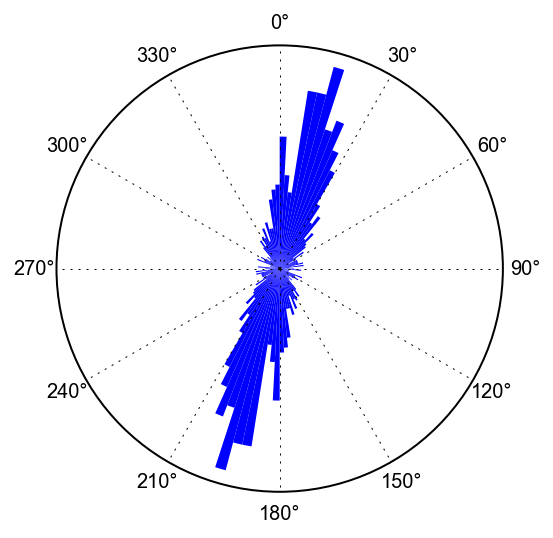

In [81]:
plt.subplot(111, polar=True)
rose(keeps.theta, bidirectional=True, bins=120, lw=0)
plt.gca().set_yticks([])
plt.gca().set_xticks(np.radians(np.arange(12) * 30))
plt.show()

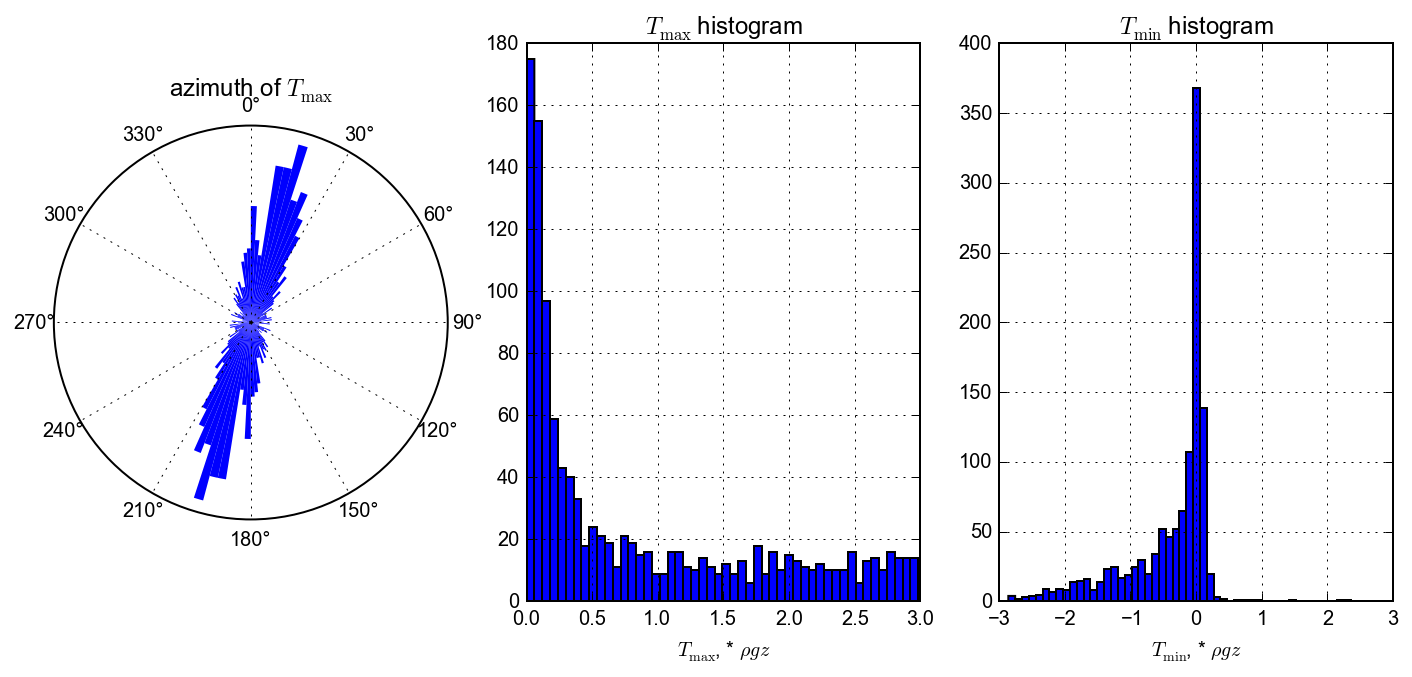

In [82]:
plt.figure(figsize=(12,5))

plt.subplot(131, polar=True)
rose(keeps.theta, bidirectional=True, bins=120, lw=0)
plt.gca().set_yticks([])
plt.gca().set_xticks(np.radians(np.arange(12) * 30))
plt.title(r'azimuth of $T_{\max}$')

plt.subplot(132)
keeps.s1.hist(bins=50)
plt.title(r'$T_{\max}$ histogram')
plt.xlabel(r'$T_{\max}$, * $\rho g z$')

plt.subplot(133)
keeps.s3.hist(bins=50)
plt.title(r'$T_{\min}$ histogram')
plt.xlabel(r'$T_{\min}$, * $\rho g z$')

plt.show()

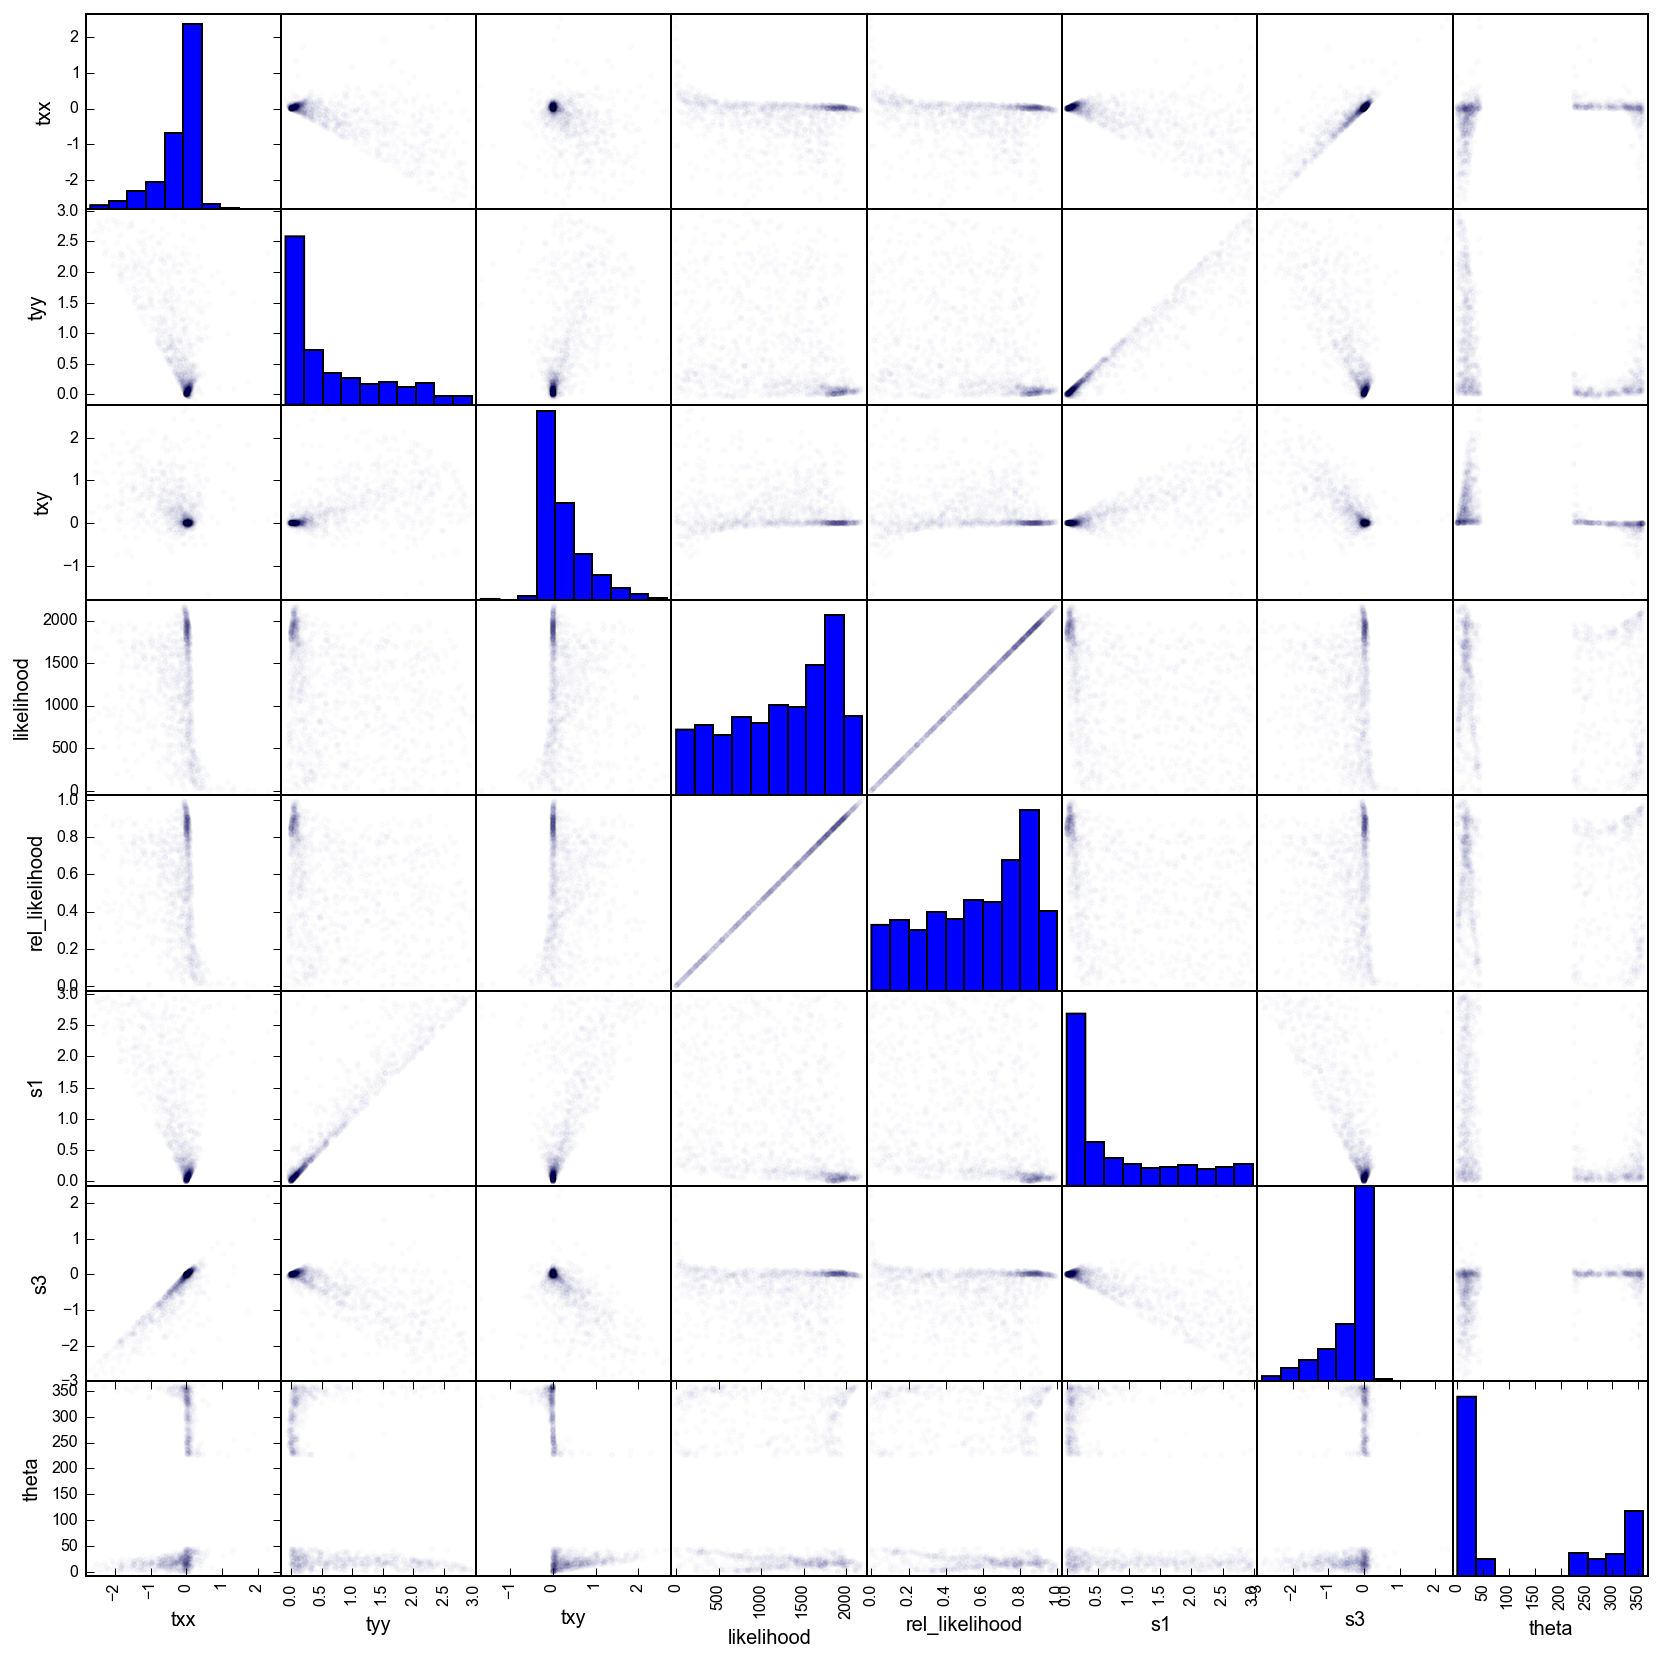

In [83]:
pd.tools.plotting.scatter_matrix(keeps, alpha=0.01, figsize=(14,14))

plt.show()

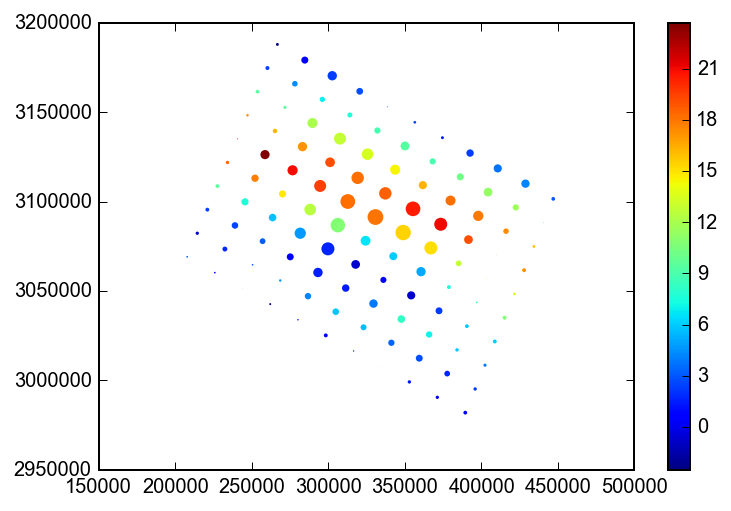

In [22]:
plt.scatter(fdf[fdf.dip==10].east,
            fdf[fdf.dip==10].north,
            c=fdf[fdf.dip==10].tau_dd,
            s=fdf[fdf.dip==10].slip_m*20,
            lw=0)
plt.colorbar()

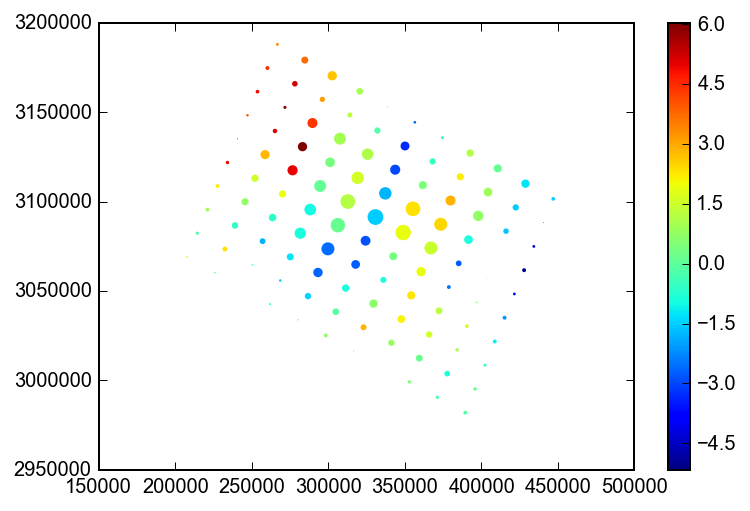

In [23]:
plt.scatter(fdf[fdf.dip==10].east,
            fdf[fdf.dip==10].north,
            c=fdf[fdf.dip==10].tau_ss,
            s=fdf[fdf.dip==10].slip_m*20,
            lw=0)
plt.colorbar()

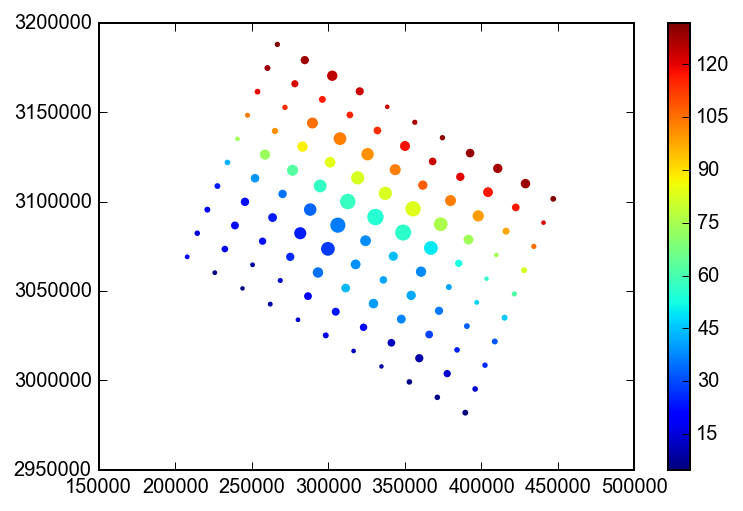

In [24]:
plt.scatter(fdf[fdf.dip==10].east,
            fdf[fdf.dip==10].north,
            c=fdf[fdf.dip==10].sig_nn,
            s=fdf[fdf.dip==10].slip_m*20 + 5,
            lw=0)
plt.colorbar()

In [25]:
mht = fdf[fdf.dip==10]

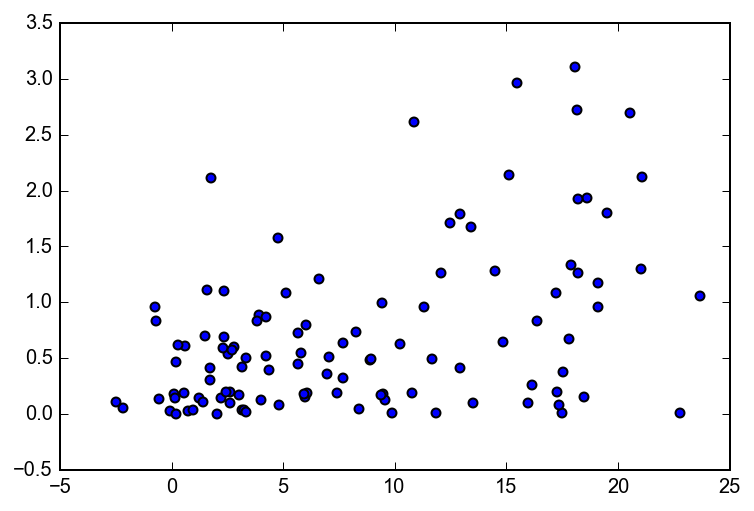

In [26]:
plt.scatter(mht.tau_dd, mht.slip_m)

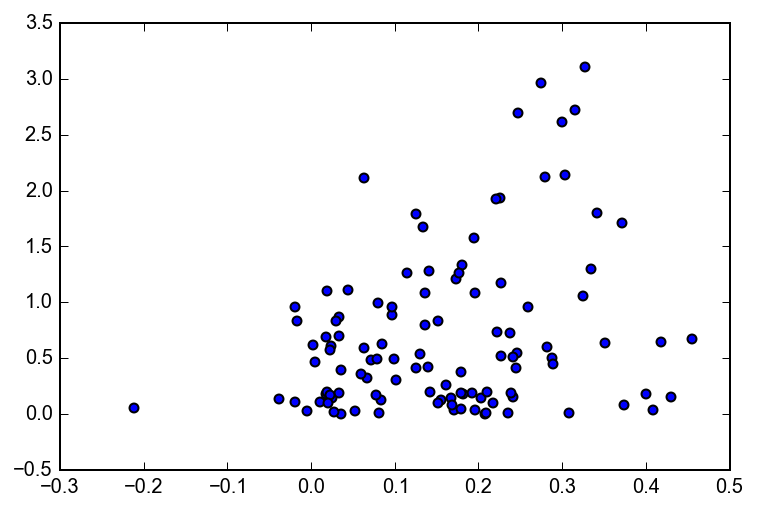

In [27]:
plt.scatter(mht.tau_dd/mht.sig_nn, mht.slip_m)

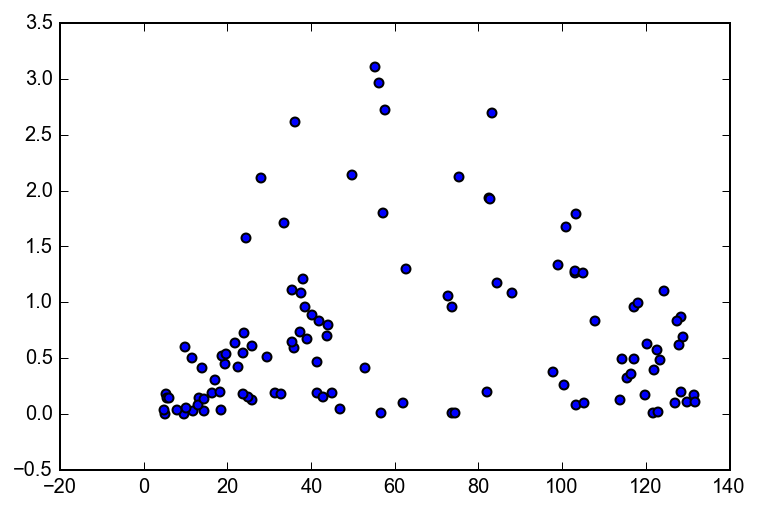

In [30]:
plt.scatter(mht.sig_nn, mht.slip_m)

In [28]:
fdf.slip_m.describe()

count    1081.000000
mean        0.116058
std         0.301500
min         0.001200
25%         0.050000
50%         0.050000
75%         0.050000
max         3.106400
Name: slip_m, dtype: float64

In [29]:
keeps.head()

,txx,tyy,txy,likelihood,rel_likelihood,s1,s3,theta
iter,,,,,,,,
6,-0.262534,0.304827,0.076388,1738.818786,0.805500,0.314931,-0.272639,7.535426
7,0.151238,0.145395,0.026907,1295.260527,0.600024,0.175382,0.121251,228.098413
41,0.196373,1.608625,1.340242,473.347795,0.219276,2.417379,-0.612381,31.108420
58,-0.722008,1.151050,0.604418,1783.717274,0.826299,1.329154,-0.900113,16.418700
64,1.730842,0.199944,1.828708,15.873192,0.007353,2.947837,-1.017051,236.356454


In [39]:
keeps.to_csv('../results/T_results.csv')

In [31]:
fdf

,east,north,depth,strike,dip,slip_m,rake,fault_name,point_index,htm_ind,zz_stress,xy_stress,xz_stress,yz_stress,xx_stress,yy_stress,tau_dd,tau_ss,sig_nn,ind
46,187652.100681,3201695.699761,-900.0,19.761917,55,0.0500,-90.0000,nan,46,30,91.660655,-23.592039,7.047159,-15.262829,116.635841,116.559867,22.818001,-8.014952,107.406454,46
47,182389.018021,3189482.756855,-905.0,19.761917,55,0.0500,-90.0000,nan,47,30,76.353217,-26.335601,-1.674472,2.729693,112.519571,123.656915,24.610810,-20.692174,115.069749,47
48,177410.108366,3184445.612939,-952.0,19.761917,55,0.0500,-90.0000,nan,48,30,94.288301,-33.332509,0.691854,9.537297,112.488335,135.714470,18.885294,-32.397864,124.934737,48
49,173003.190810,3180027.682572,-1285.0,19.761917,55,0.0500,-90.0000,nan,49,30,112.830067,-32.452741,-4.658254,-3.281453,125.441811,117.593029,14.087774,-15.785102,137.625834,49
50,168449.167252,3177094.112030,-1284.0,19.761917,55,0.0500,-90.0000,nan,50,30,98.725853,-18.535620,10.384544,-18.818548,127.878486,116.612641,24.153216,-0.631182,110.175997,50
51,169442.346921,3162911.142430,-1519.0,19.761917,55,0.0500,-90.0000,nan,51,30,80.838655,0.302821,6.828743,-16.467068,96.260766,80.903218,10.432867,11.758882,78.608712,51
52,213941.122581,3294720.506196,-1377.0,19.761917,55,0.0500,-90.0000,nan,52,30,131.327393,0.072136,-2.219623,-7.545575,103.996311,100.667514,-12.883643,5.416774,112.267336,52
53,208674.124447,3285966.449153,-1238.0,19.761917,55,0.0500,-90.0000,nan,53,30,122.604192,-0.115091,4.276776,-1.330096,104.100926,98.192321,-7.446236,1.355951,105.579445,53
54,203644.213075,3266265.350429,-1169.0,19.761917,55,0.0500,-90.0000,nan,54,30,126.592360,4.316518,8.229161,-1.895715,110.811905,102.198415,-6.299723,4.399970,105.619723,54
55,204091.911063,3258755.110814,-1323.0,19.761917,55,0.0500,-90.0000,nan,55,30,123.935071,0.891283,8.178732,-0.198042,115.609107,100.395036,-2.340169,3.049546,109.504806,55


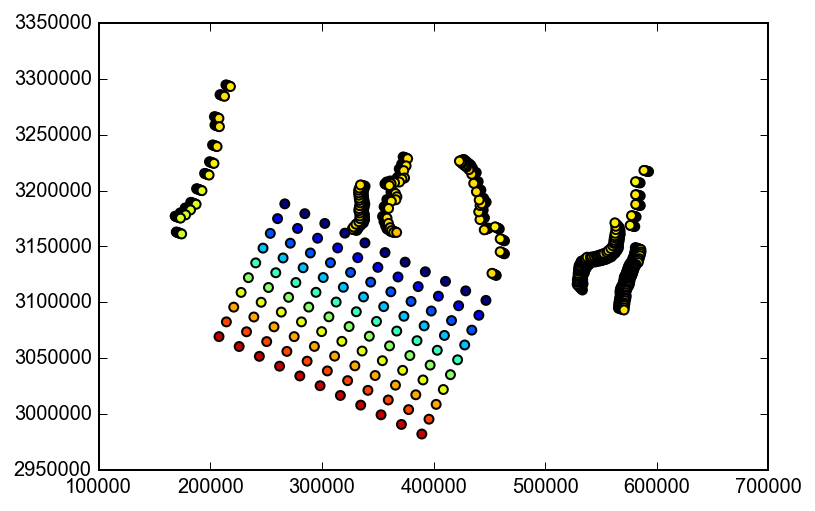

In [32]:
plt.scatter(fdf.east, fdf.north, c=fdf.depth)